Index(['CustomerID', 'TotalValue', 'Quantity', 'TransactionID', 'Region'], dtype='object')
   TotalValue  Quantity  TransactionID  Region_Europe  Region_North America  \
0     3354.52        12              5          False                 False   
1     1862.74        10              4          False                 False   
2     2725.38        14              4          False                 False   
3     5354.88        23              8          False                 False   
4     2034.24         7              3          False                 False   

   Region_South America  
0                  True  
1                 False  
2                  True  
3                  True  
4                 False  
Davies-Bouldin Index: 0.9880667545355788
Silhouette Score: 0.3963774629731389


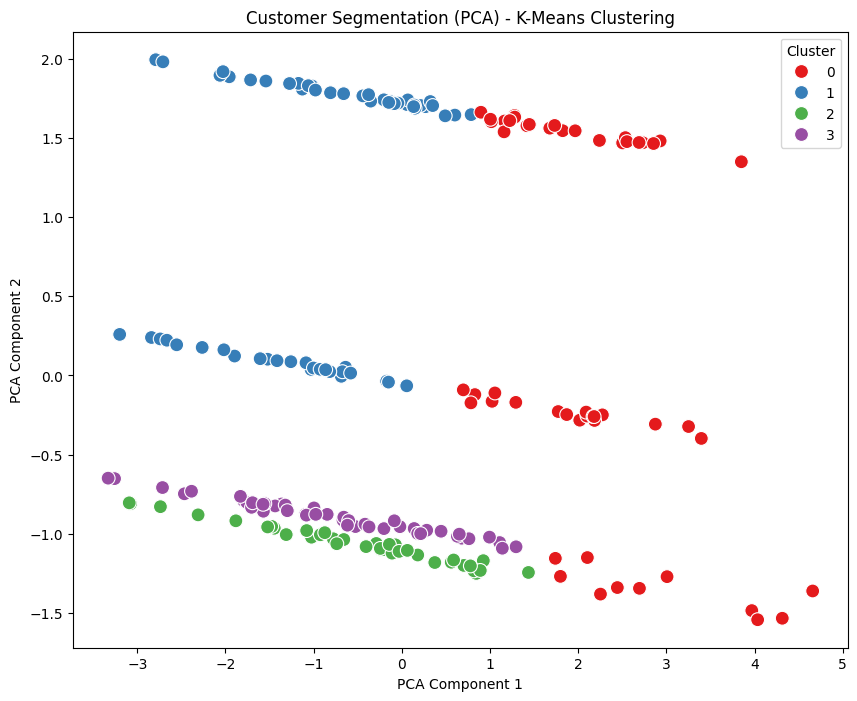

Cluster Centers (in original feature space):
[[ 1.18666019  1.27273073  1.15494144 -0.40193429 -0.22900107  0.31929776]
 [-0.57803561 -0.63727151 -0.61460251 -0.57928445 -0.54831888  0.62220027]
 [-0.37338577 -0.30591192 -0.19854986 -0.57928445  1.82375628 -0.6491753 ]
 [-0.24578428 -0.32044781 -0.30887294  1.72626765 -0.54831888 -0.6491753 ]]

Cluster Summary:
  Cluster   TotalValue                Quantity           TransactionID  \
                  mean          std       mean       std          mean   
0       0  5636.609231  1352.555370  20.557692  4.021576      7.557692   
1       1  2410.626290  1144.512379   8.838710  3.530632      3.677419   
2       2  2784.740000  1142.985346  10.871795  3.981401      4.589744   
3       3  3018.004130  1496.568240  10.782609  4.396529      4.347826   

             
        std  
0  1.513514  
1  1.423160  
2  1.901771  
3  1.523408  
Clustering results saved to 'Abilash_K S_Clustering.csv'.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the data (Assuming 'Customers.csv' and 'Transactions.csv' are available)
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Prepare Transaction Data for Lookalike Model
# Merge transactions with customer data
merged_data = transactions.merge(customers, on="CustomerID", how="inner")

# Aggregate transaction data per customer
customer_transactions = merged_data.groupby("CustomerID").agg({
    'TotalValue': 'sum',  # Total value of all transactions for each customer
    'Quantity': 'sum',    # Total quantity of all products purchased by each customer
    'TransactionID': 'count'  # Number of transactions per customer
}).reset_index()

# Merge with customer profile data (ensure 'Region' is included)
customer_profile = customers[['CustomerID', 'Region']]  # Select Region from customers
customer_data = customer_transactions.merge(customer_profile, on="CustomerID")

# Debugging: Check if 'Region' is available in the merged data
print(customer_data.columns)  # Ensure 'Region' is in the list of columns

# Step 2: Feature Engineering
# We will create a feature set: TotalValue, Quantity, Number of Transactions, Region (one-hot encoded)
X = customer_data[['TotalValue', 'Quantity', 'TransactionID', 'Region']]  # Include Region here

# One-hot encode the 'Region' column
X = pd.get_dummies(X, columns=['Region'], drop_first=True)

# Check the shape of the data after one-hot encoding to confirm it's correct
print(X.head())

# Standardize the data (important for clustering algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Clustering (Using K-Means)
# Choose the number of clusters (let's try K=4 as a start)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Evaluate the Clustering

# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Silhouette Score for cluster validity
sil_score = silhouette_score(X_scaled, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Step 5: Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA components to the dataframe for visualization
customer_data['PCA1'] = pca_components[:, 0]
customer_data['PCA2'] = pca_components[:, 1]

# Step 6: Visualizing the Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='Set1', s=100)
plt.title('Customer Segmentation (PCA) - K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 7: Output the Clustering Results
print("Cluster Centers (in original feature space):")
print(kmeans.cluster_centers_)

# Additional cluster analysis
cluster_summary = customer_data.groupby("Cluster").agg({
    'TotalValue': ['mean', 'std'],
    'Quantity': ['mean', 'std'],
    'TransactionID': ['mean', 'std']
}).reset_index()

print("\nCluster Summary:")
print(cluster_summary)

# Save clustering results to CSV (Optional)
customer_data[['CustomerID', 'Cluster']].to_csv('Abilash_K S_Clustering.csv', index=False)
print("Clustering results saved to 'Abilash_K S_Clustering.csv'.")
